In [1]:
import cv2
import pandas as pd
import numpy as np
from csv import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
from keras.layers import concatenate
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from keras.applications.densenet import DenseNet121
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras import vis.utilis

In [3]:
train_csv = r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\train\Ground_Truth.csv"
train_img = r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\train\train images"
test_img = r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\test_images-20230331T075032Z-001\test_images"
lis = (os.listdir(r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\train\train images"))

In [4]:
def image_equalization(image):
    
    R, G, B = cv2.split(image)
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    equ = cv2.merge((output1_R, output1_G, output1_B))
    
    return equ

def preprocess_image(img_arr):

    img_arr = img_arr.astype('float16')
    img_arr /= 255
    if len(img_arr.shape) > 2:
        img_arr = img_arr[:, :, 0]
    # Convert to 3-channel
    img_arr = np.stack((img_arr, img_arr, img_arr), axis=-1)
    # Convert to array
    img_arr = cv2.resize(img_arr, (224, 224))
    return img_arr


In [5]:
y  = []
y1 = []
df = pd.read_csv(train_csv)
for i in range(len(lis)):
    if df.iloc[i][0] in lis:
        if df.iloc[i][1] == "No Finding":
            y.append(0)
        else:
            y.append(1)

        img_arr = cv2.imread(train_img+chr(92)+df.iloc[i][0])

        resized_img = cv2.resize(img_arr, (224, 224),interpolation = cv2.INTER_CUBIC)
        #print(resized_img.shape)
        eq_img = image_equalization(resized_img)

        y1.append(eq_img.astype(np.float16))

In [6]:
print(len(y1))

13971


In [7]:
X_train, X_val, y_train, y_val = train_test_split(y1, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

X_train/=255
X_val/=255

In [8]:
folds = list(StratifiedKFold(n_splits=3,shuffle=True,random_state=1).split(X_train,y_train))

In [9]:
lis2 = os.listdir(test_img)
X_test = []
for item in lis2:
    img = cv2.imread(test_img+chr(92)+item)
    resized_img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_CUBIC)
    X_test.append(resized_img.astype(np.float16))

X_test = np.array(X_test)
X_test/=255

In [10]:
model_1 = load_model(r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\CheXpert_DenseNet121_res224.h5")
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [ ]:
input_layer = Input(shape = (224, 224, 3))

model_1 = load_model(r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\CheXpert_DenseNet121_res224.h5")
opt1 = model_1.layers[-2].output

for layer in model_1.layers:
    layer.trainable =  False

x = BatchNormalization()(opt1)
x = Dense(256,activation = "relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)
stacked_model = keras.Model(inputs = model_1.input, outputs = x)
stacked_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
for j, (train_idx,val_idx) in enumerate(folds):
    print('\nFold',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_val_cv = X_train[val_idx]
    y_val_cv = y_train[val_idx]

    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
    mcp_save = ModelCheckpoint('./hopefully_final.hd5',save_best_only=True,monitor='val_accuracy',mode='max')
    stacked_model.fit(X_train_cv, y_train_cv,epochs=10, validation_data=(X_val_cv, y_val_cv), callbacks=[early_stop, mcp_save])

In [12]:
model_1_wts = load_model(r"C:\Users\ABHINAV\Downloads\train-20230326T213916Z-001\hopefully_final.hd5")
opt = model_1_wts.predict(X_test)

32/32 [==============================] - 100s 3s/step


In [17]:
opt2 = model_1_wts.predict(X_val)

88/88 [==============================] - 212s 2s/step


In [19]:
lis3 = []
for i in range(opt2.shape[0]):
    if opt2[i] < 0.4689999:
        lis3.append(0)
    else:
        lis3.append(1)

In [25]:
import numpy as np
accu = []

# Define the predicted probabilities and ground truth labels
pred_probs = opt2
ground_truth = y_val

# Create an array of threshold values
thresholds = np.arange(0, 1, 0.01)

# Initialize variables to store the best threshold and best accuracy
best_threshold = 0
best_accuracy = 0

# Iterate over the threshold values
for threshold in thresholds:
    # Convert predicted probabilities to predicted class labels
    pred_labels = (pred_probs >= threshold).astype(int)
    
    # Calculate the accuracy of the predicted labels
    accuracy = np.mean(pred_labels == ground_truth)
    accu.append((threshold,accuracy))

    
    # Update best threshold and best accuracy if current accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Print the best threshold and best accuracy
print(f"Best threshold: {best_threshold:.2f}")
print(f"Best accuracy: {best_accuracy:.2f}")

Best threshold: 0.99
Best accuracy: 0.59


In [26]:
for i in range(len(accu)):
    print(accu[i][1])

0.40608228980322003
0.40608228980322003
0.40608228980322003
0.40608228980322003
0.40608228980322003
0.40608228980322003
0.40608228980322003
0.40608228980322003
0.4062166979752369
0.4064183102332622
0.40695594292132964
0.4073591674373802
0.40836722872750664
0.4098457186196921
0.4111898003398607
0.41300431066208826
0.4150204332423411
0.41811182119872886
0.42073278055305763
0.4232193317353695
0.4271843728098668
0.4308805975403305
0.4337703732386929
0.43780261839919865
0.4410956186136117
0.4453966801181512
0.4492945171066401
0.453662782697188
0.45843427280378646
0.46293694656635126
0.467910048930975
0.47214390634950604
0.47651217194005396
0.4808132334445934
0.4851142949491329
0.4885417033355628
0.492170723980018
0.494522866990313
0.4980846835487598
0.5013104796771644
0.5042002553755268
0.5068212147298555
0.5092405618261591
0.5121975416105299
0.5137432355887238
0.5156249499969598
0.5173050521471706
0.5196571951574656
0.5217405218237269
0.5234206239739376
0.5251679302101567
0.527184052790409

In [32]:
df2 = pd.DataFrame()
df2["Image Index"] = lis2
df2["Finding Labels"] = lis3
df2.to_csv("opt3.csv", index=False)

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
import vis 
from vis.utils import utils
from keras.utils.vis_utils import visualize_cam
penultimate_layer_idx = utils.find_layer_idx()

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, n(lis_3))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

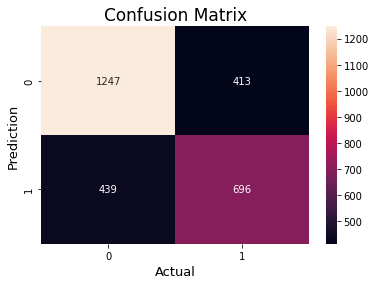

In [20]:
#Import the necessary libraries

import numpy as np

from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

#Create the NumPy array for actual and predicted labels.

actual    = np.array(

  y_val)

predicted = np.array(

  lis3)

#compute the confusion matrix.

cm = confusion_matrix(actual,predicted)

#Plot the confusion matrix.

sns.heatmap(cm,

            annot=True,

            fmt='g',

            xticklabels=['0','1'],

            yticklabels=['0','1'])

plt.ylabel('Prediction',fontsize=13)

plt.xlabel('Actual',fontsize=13)

plt.title('Confusion Matrix',fontsize=17)

plt.show()
